In [15]:
import os

from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import pyro
import torch
import zuko
from click import command, option
import pandas as pd
import seaborn as sns

import wandb
from scripts.training import train
from scripts.uav.data import load_all_data
from scripts.uav.model import model as uav_model
from scripts.utils import kl_divergence, ConditionalGaussianMixture

In [81]:
# Load training and eval data
with torch.no_grad():
    nominal_data, _, rudder_data = load_all_data()  # elevator failure data not used

    # Unpack nominal data into tensors (concatenate trajectories)
    (
        _,  # time unused
        nominal_initial_states,
        nominal_next_states,
        nominal_pqrs,
        nominal_commands,
    ) = nominal_data
    nominal_initial_states_train = torch.cat(nominal_initial_states[1:])
    nominal_next_states_train = torch.cat(nominal_next_states[1:])
    nominal_pqrs_train = torch.cat(nominal_pqrs[1:])
    nominal_commands_train = torch.cat(nominal_commands[1:])

    # These are all N x 3, so stack into N x 4 x 3
    nominal_observations = torch.stack(
        (
            nominal_initial_states_train,
            nominal_next_states_train,
            nominal_pqrs_train,
            nominal_commands_train,
        ),
        dim=1,
    )
    n_nominal = nominal_observations.shape[0]

    nominal_initial_states_eval = torch.cat(nominal_initial_states[:1])
    nominal_next_states_eval = torch.cat(nominal_next_states[:1])
    nominal_pqrs_eval = torch.cat(nominal_pqrs[:1])
    nominal_commands_eval = torch.cat(nominal_commands[:1])

    # These are all N x 3, so stack into N x 4 x 3
    nominal_observations_eval = torch.stack(
        (
            nominal_initial_states_eval,
            nominal_next_states_eval,
            nominal_pqrs_eval,
            nominal_commands_eval,
        ),
        dim=1,
    )
    n_nominal_eval = nominal_observations_eval.shape[0]

    # Unpack failure data into tensors (concatenate trajectories)
    (
        t,
        failure_initial_states,
        failure_next_states,
        failure_pqrs,
        failure_commands,
    ) = rudder_data
    failure_initial_states_train = torch.cat(failure_initial_states[:1])
    failure_next_states_train = torch.cat(failure_next_states[:1])
    failure_pqrs_train = torch.cat(failure_pqrs[:1])
    failure_commands_train = torch.cat(failure_commands[:1])
    failure_observations_train = torch.stack(
        (
            failure_initial_states_train,
            failure_next_states_train,
            failure_pqrs_train,
            failure_commands_train,
        ),
        dim=1,
    )
    n_failure = failure_observations_train.shape[0]

    failure_initial_states_eval = torch.cat(failure_initial_states[1:])
    failure_next_states_eval = torch.cat(failure_next_states[1:])
    failure_pqrs_eval = torch.cat(failure_pqrs[1:])
    failure_commands_eval = torch.cat(failure_commands[1:])
    failure_observations_eval = torch.stack(
        (
            failure_initial_states_eval,
            failure_next_states_eval,
            failure_pqrs_eval,
            failure_commands_eval,
        ),
        dim=1,
    )
    n_failure_eval = failure_observations_eval.shape[0]

In [17]:
def single_particle_elbo(guide_dist, n, obs):
    posterior_sample, posterior_logprob = guide_dist.rsample_and_log_prob()

    # Reshape the sample
    A = posterior_sample[:9].reshape(3, 3)
    K = posterior_sample[9:18].reshape(3, 3)
    d = posterior_sample[18:21].reshape(3)
    log_noise_strength = posterior_sample[21]

    # Unpack the observations
    initial_states = obs[:, 0]
    next_states = obs[:, 1]
    pqrs = obs[:, 2]
    commands = obs[:, 3]

    model_trace = pyro.poutine.trace(
        pyro.poutine.condition(
            uav_model,
            data={
                "A": A,
                "K": K,
                "d": d,
                "log_noise_strength": log_noise_strength,
            },
        )
    ).get_trace(
        initial_states=initial_states,
        commands=commands,
        observed_next_states=next_states,
        observed_pqrs=pqrs,
        dt=0.25,
        device=obs.device,
    )
    model_logprob = model_trace.log_prob_sum()

    return model_logprob - posterior_logprob

In [31]:
# Load a model from a file
model_path = "./models/uav_balanced.pt"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_calibration_permutations = 6
ours_failure_guide = zuko.flows.NSF(
    features=2 * 3 * 3 + 3 + 1,
    context=n_calibration_permutations,
    hidden_features=(64, 64),
).to(device)
state_dict = torch.load(model_path, map_location=device)
ours_mixture_label = state_dict["mixture_label"]
ours_failure_guide.load_state_dict(state_dict["failure_guide"])

# Load a second model to compare
model_path = "./models/uav_kl.pt"
kl_failure_guide = zuko.flows.NSF(
    features=2 * 3 * 3 + 3 + 1,
    context=n_calibration_permutations,
    hidden_features=(64, 64),
).to(device)
state_dict = torch.load(model_path, map_location=device)
kl_failure_guide.load_state_dict(state_dict["failure_guide"])

<All keys matched successfully>

In [44]:
pqr_obs[:, col].cpu().shape
pqr_pred[:, col].cpu().shape

torch.Size([68, 1])

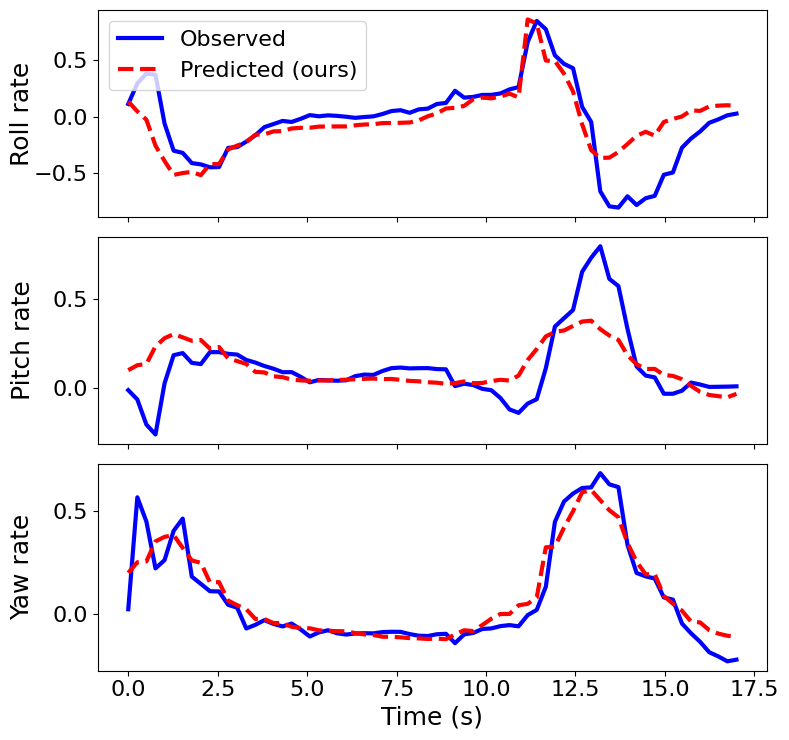

In [108]:
# Plot the predicted failure trajectory on the test trajectory
fig, axs = plt.subplots(
    3, 1, figsize=(8 * 1, 2.5 * 3), sharex=True
)

(initial_states, _, pqr_obs, commands) = failure_observations_eval.transpose(0, 1)

# posterior_sample = kl_failure_guide(torch.ones(n_calibration_permutations, device=device)).sample((100,)).mean(dim=0)
# A = posterior_sample[:9].reshape(3, 3)
# K = posterior_sample[9:18].reshape(3, 3)
# d = posterior_sample[18:21].reshape(3, 1)
# states = initial_states.reshape(-1, 3, 1)
# commands = commands.reshape(-1, 3, 1)
# errors = commands - states
# pqr_pred = A @ states + K @ errors + d

# for col in range(3):
#     var = ["$p$", "$q$", "$r$"][col]
#     # axs[col].plot(pqr_obs[:, col].cpu(), "b-", label="Observed")
#     axs[col].plot(
#         (pqr_obs[:, col, None].cpu() - pqr_pred[:, col].cpu()), "r:", label="Predicted (KL-reg.)"
#     )

#     axs[col].set_ylabel(var, rotation=0, labelpad=10)



posterior_sample = ours_failure_guide(ours_mixture_label).sample((100,)).mean(dim=0)
A = posterior_sample[:9].reshape(3, 3)
K = posterior_sample[9:18].reshape(3, 3)
d = posterior_sample[18:21].reshape(3, 1)
states = initial_states.reshape(-1, 3, 1)
commands = commands.reshape(-1, 3, 1)
errors = commands - states
pqr_pred = A @ states + K @ errors + d

t = torch.linspace(0, 0.25 * pqr_obs.shape[0], pqr_obs.shape[0])
for col in range(3):
    var = ["Roll rate", "Pitch rate", "Yaw rate"][col]
    axs[col].plot(t, pqr_obs[:, col].cpu(), "b-", label="Observed", linewidth=3)
    axs[col].plot(t, 
        # (pqr_obs[:, col, None].cpu() - pqr_pred[:, col].cpu()), "r--", label="Predicted (ours)"
        pqr_pred[:, col].cpu(), "r--", label="Predicted (ours)", linewidth=3
    )

    if col == 0:
        axs[col].set_ylabel(var, fontsize=18, labelpad=0)
        axs[col].legend(fontsize=16, loc="upper left")
    else:
        axs[col].set_ylabel(var, fontsize=18, labelpad=13)

    # Increase font size
    axs[col].tick_params(axis="both", which="major", labelsize=16)

    if col == 2:
        axs[col].set_xlabel("Time (s)", fontsize=18)

fig.tight_layout()